In [3]:
%reset
# Imports
import numpy as np # Numerical computing library
from scipy.integrate import odeint # Integration solver for ordinary Differential Equations
import matplotlib.pyplot as plt # Plotting library

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [4]:
#############################
# RUNGE-KUTTA METHOD
#############################

numpoints = 100 # Number of increments to use in simulation

# Constants
L = 25 #[m] length of the bridge
m = 2303 #[kg/m] Mass of bridge deck per metre
M_v = 5750 #[kg] Vehicle mass
g = 9.81 #[m/s^2] Gravity assumed positive downward
v = (100E3)/ (60 * 60) #27.778[m/s] Vehicle horizontal velocity
w_1 = 30.02 #[rad/s] First mode natural frequency of bridge deck
w_v = 16.66 #[rad/s] Vehicle sprung mass natural frequency
k = 1595E3 # [N/m] Vehicle spring stiffness

#Groups
a = (2 * M_v) / (m * L)
b = (np.pi * v ) / L

# Initial conditions
x1 = 0.0
y1 = 0.0
x2 = 0.0
y2 = 0.0

# Time vector
t_start = 0.0 # [s]
t_end = 0.9 # [s]
t = np.linspace(t_start, t_end, numpoints) # a vector containing the times at which solutions will be estimated
dt = (t_end - t_start) / numpoints # the time increment used, given the start and end times and the number of increments
fs = 1/dt # the effective sampling frequency

def dx1dt(y1):
    dx1dt = y1
    return dx1dt

def dy1dt(x1, x2, t):
    dy1dt = -(a * g * np.sin(b * t)) + (x2 * (a * w_v * w_v * np.sin(b * t))) - (x1 * ((a * w_v * w_v * np.sin(b * t) * np.sin(b * t)) + (w_1 * w_1)))
    return dy1dt
    
def dx2dt(y2):
    dx2dt = y2
    return dx2dt

def dy2dt(x1, x2, t):
    dy2dt = (x1 * (w_v * w_v * np.sin(b * t))) - (x2 * w_v * w_v)
    return dy2dt

# Results vectors
x1_res = np.zeros(len(t)).astype(float)
y1_res = np.zeros(len(t)).astype(float)
x2_res = np.zeros(len(t)).astype(float)
y2_res = np.zeros(len(t)).astype(float)

for i in range(len(t)):
    
    # Write current value of each variable to results vector
    x1_res[i] = x1
    y1_res[i] = y1
    x2_res[i] = x2
    y2_res[i] = y2
    
    # Increment and store results temporarily
    k1x1 = dt * dx1dt(y1)
    k1y1 = dt * dy1dt(x1, x2, t[i])
    k1x2 = dt * dx2dt(y2)
    k1y2 = dt * dy2dt(x1, x2, t[i])

    k2x1 = dt * dx1dt(y1 + 0.5 * k1y1)
    k2y1 = dt * dy1dt((x1 + 0.5 * k1x1), (x2 + 0.5 * k1x2), (t[i] + 0.5 * dt))
    k2x2 = dt * dx2dt(y2 + 0.5 * k1y2)
    k2y2 = dt * dy2dt((x1 + 0.5 * k1x1), (x2 + 0.5 * k1x2), (t[i] + 0.5 * dt))

    k3x1 = dt * dx1dt(y1 + 0.5 * k2y1)
    k3y1 = dt * dy1dt((x1 + 0.5 * k2x1), (x2 + 0.5 * k2x2), (t[i] + 0.5 * dt))
    k3x2 = dt * dx2dt(y2 + 0.5 * k2y2)
    k3y2 = dt * dy2dt((x1 + 0.5 * k2x1), (x2 + 0.5 * k2x2), (t[i] + 0.5 * dt))

    k4x1 = dt * dx1dt(y1 + k3y1)
    k4y1 = dt * dy1dt((x1 + k3x1), (x2 + k3x2), (t[i] + dt))
    k4x2 = dt * dx2dt(y2 + k3y2)
    k4y2 = dt * dy2dt((x1 + k3x1), (x2 + k3x2), (t[i] + dt))
    
    # Assign temporary results to placeholders
    x1_next = x1 + (k1x1 / 6) + (k2x1 / 3) + (k3x1 / 3) + (k4x1 / 6)
    y1_next = y1 + (k1y1 / 6) + (k2y1 / 3) + (k3y1 / 3) + (k4y1 / 6)
    x2_next = x2 + (k1x2 / 6) + (k2x2 / 3) + (k3x2 / 3) + (k4x2 / 6)
    y2_next = y2 + (k1y2 / 6) + (k2y2 / 3) + (k3y2 / 3) + (k4y2 / 6)
    
    # Update current value for each variable
    x1 = x1_next
    y1 = y1_next
    x2 = x2_next
    y2 = y2_next
    
# Estimate accelerations
z1_res = np.gradient(y1_res, dt)
z2_res = np.gradient(y2_res, dt)

In [5]:
###########################################
# --BIGGS EQUATIONS--
###########################################

# Right hand side of differential equation system (four 1st-order equations)
def RHS(s, t, p):
    [a, b, c, W_v, M_v, k_v, g] = p
    [x1, y1, x2, y2] = s
    f = [y1,
    ((a * (W_v + (k_v * x2))) * np.sin(b * t)) - (x1 * ((w_1 * w_1) + (a * k_v * (np.sin(b * t) * np.sin(b * t))))),
    y2,
    (x1 * c * np.sin(b * t)) - (x2 * c)]
    return f

# Initial conditions
# NOTE: s takes form [x1, y1, x2, y2]
s0 = np.array([0, 0, 0, 0])

# Time
numpoints_biggs = 100
t_spacing_biggs = 1/numpoints_biggs
t_biggs = np.linspace(0, 0.9, numpoints_biggs)

# Constants
g = -9.81 #[m/s^2] This method assumes gravity is positive upwards, so define as negative

#Groups
a_1 = 2 / (m * L)
b_1 = (np.pi * v ) / L
c_1 = k / M_v
W_v = M_v * g

# Pack up
p_1 = [a_1, b_1, c_1, W_v, M_v, k, g]

# Solve
result_1 = odeint(RHS, s0, t_biggs, args=(p_1,))

# Extract results
x1_1, y1_1, x2_1, y2_1 = result_1.T[0], result_1.T[1], result_1.T[2], result_1.T[3]

z1_1 = np.gradient(y1_1, t_spacing_biggs)
z2_1 = np.gradient(y2_1, t_spacing_biggs)

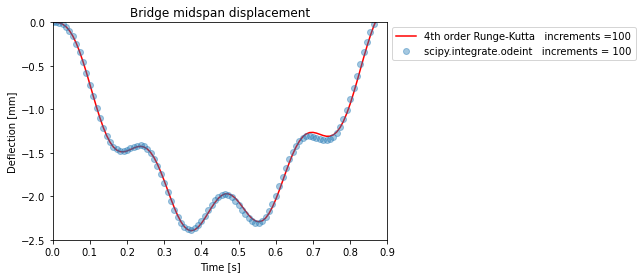

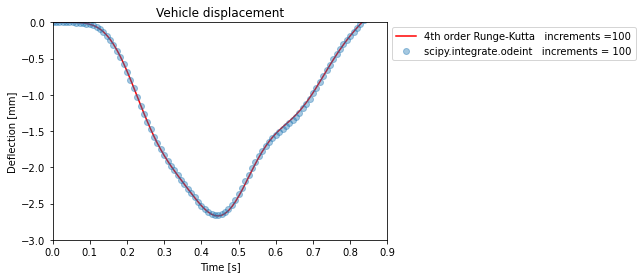

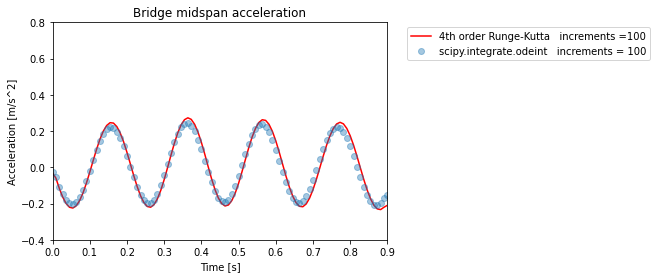

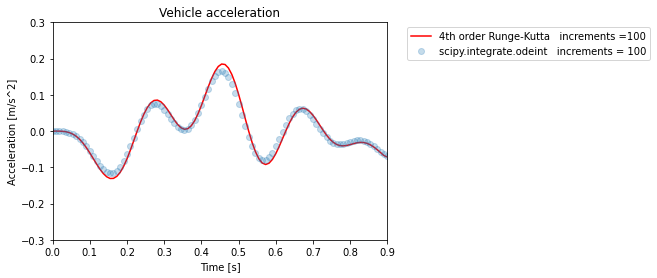

In [6]:
#############################
# PLOT FOR COMPARISON
# Linetypes version 1
#############################

# Plot bridge midspan displacement
plt.plot(t, 1E3 * x1_res, 'r')
plt.plot(t_biggs, 1E3 * x1_1, 'o', alpha=0.4)
plt.xlabel('Time [s]')
plt.ylabel('Deflection [mm]')
plt.title('Bridge midspan displacement')
plt.legend(['4th order Runge-Kutta' + '   increments =' + str(numpoints), 
            'scipy.integrate.odeint' + '   increments = ' + str(numpoints_biggs)], bbox_to_anchor =(1,1))
plt.xlim(0, 0.9)
plt.ylim(-2.5, 0)
plt.show()

# Plot vehicle displacement
plt.plot(t, 1E3 * x2_res, 'r')
plt.plot(t_biggs, 1E3 * x2_1, 'o', alpha=0.4)
plt.xlabel('Time [s]')
plt.ylabel('Deflection [mm]')
plt.title('Vehicle displacement')
plt.legend(['4th order Runge-Kutta' + '   increments =' + str(numpoints), 
            'scipy.integrate.odeint' + '   increments = ' + str(numpoints_biggs)], bbox_to_anchor =(1,1))
plt.xlim(0, 0.9)
plt.ylim(-3, 0)
plt.show()

# Plot bridge midspan acceleration
plt.plot(t, z1_res, 'r')
plt.plot(t_biggs, z1_1, 'o', alpha=0.4)
plt.xlabel('Time [s]')
plt.ylabel('Acceleration [m/s^2]')
plt.title('Bridge midspan acceleration')
plt.legend(['4th order Runge-Kutta' + '   increments =' + str(numpoints), 
            'scipy.integrate.odeint' + '   increments = ' + str(numpoints_biggs)], bbox_to_anchor =(1.8,1))
plt.xlim(0, 0.9)
plt.ylim(-0.4, 0.8)
plt.show()

# Plot vehicle acceleration
plt.plot(t, z2_res, 'r')
plt.plot(t_biggs, z2_1, 'o', alpha=0.25)
plt.xlabel('Time [s]')
plt.ylabel('Acceleration [m/s^2]')
plt.title('Vehicle acceleration')
plt.legend(['4th order Runge-Kutta' + '   increments =' + str(numpoints), 
            'scipy.integrate.odeint' + '   increments = ' + str(numpoints_biggs)], bbox_to_anchor =(1.8,1))
plt.xlim(0, 0.9)
plt.ylim(-0.3, 0.3)
plt.show()

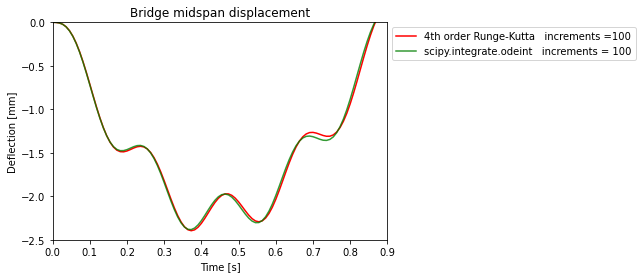

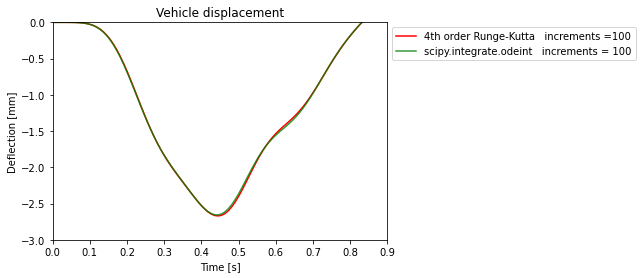

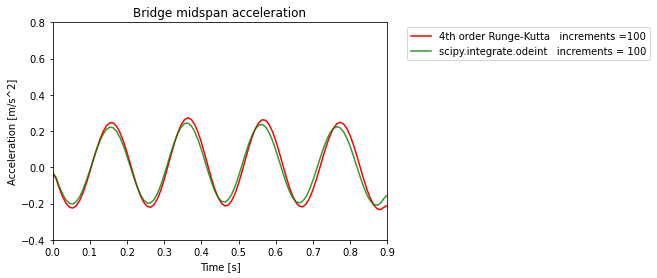

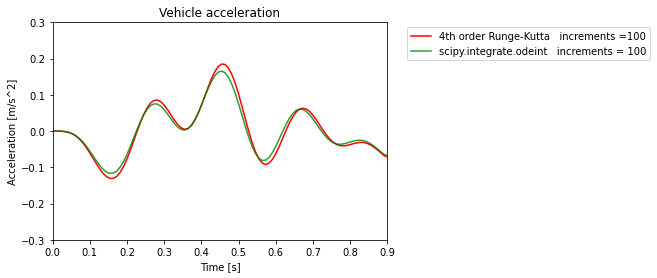

In [7]:
#############################
# PLOT FOR COMPARISON
# Linetypes version 2
#############################

# Plot bridge midspan displacement
plt.plot(t, 1E3 * x1_res, 'r')
plt.plot(t_biggs, 1E3 * x1_1, 'g', alpha=0.8)
plt.xlabel('Time [s]')
plt.ylabel('Deflection [mm]')
plt.title('Bridge midspan displacement')
plt.legend(['4th order Runge-Kutta' + '   increments =' + str(numpoints), 
            'scipy.integrate.odeint' + '   increments = ' + str(numpoints_biggs)], bbox_to_anchor =(1,1))
plt.xlim(0, 0.9)
plt.ylim(-2.5, 0)
plt.show()

# Plot vehicle displacement
plt.plot(t, 1E3 * x2_res, 'r')
plt.plot(t_biggs, 1E3 * x2_1, 'g', alpha=0.8)
plt.xlabel('Time [s]')
plt.ylabel('Deflection [mm]')
plt.title('Vehicle displacement')
plt.legend(['4th order Runge-Kutta' + '   increments =' + str(numpoints), 
            'scipy.integrate.odeint' + '   increments = ' + str(numpoints_biggs)], bbox_to_anchor =(1,1))
plt.xlim(0, 0.9)
plt.ylim(-3, 0)
plt.show()

# Plot bridge midspan acceleration
plt.plot(t, z1_res, 'r')
plt.plot(t_biggs, z1_1, 'g', alpha=0.8)
plt.xlabel('Time [s]')
plt.ylabel('Acceleration [m/s^2]')
plt.title('Bridge midspan acceleration')
plt.legend(['4th order Runge-Kutta' + '   increments =' + str(numpoints), 
            'scipy.integrate.odeint' + '   increments = ' + str(numpoints_biggs)], bbox_to_anchor =(1.8,1))
plt.xlim(0, 0.9)
plt.ylim(-0.4, 0.8)
plt.show()

# Plot vehicle acceleration
plt.plot(t, z2_res, 'r')
plt.plot(t_biggs, z2_1, 'g', alpha=0.8)
plt.xlabel('Time [s]')
plt.ylabel('Acceleration [m/s^2]')
plt.title('Vehicle acceleration')
plt.legend(['4th order Runge-Kutta' + '   increments =' + str(numpoints), 
            'scipy.integrate.odeint' + '   increments = ' + str(numpoints_biggs)], bbox_to_anchor =(1.8,1))
plt.xlim(0, 0.9)
plt.ylim(-0.3, 0.3)
plt.show()

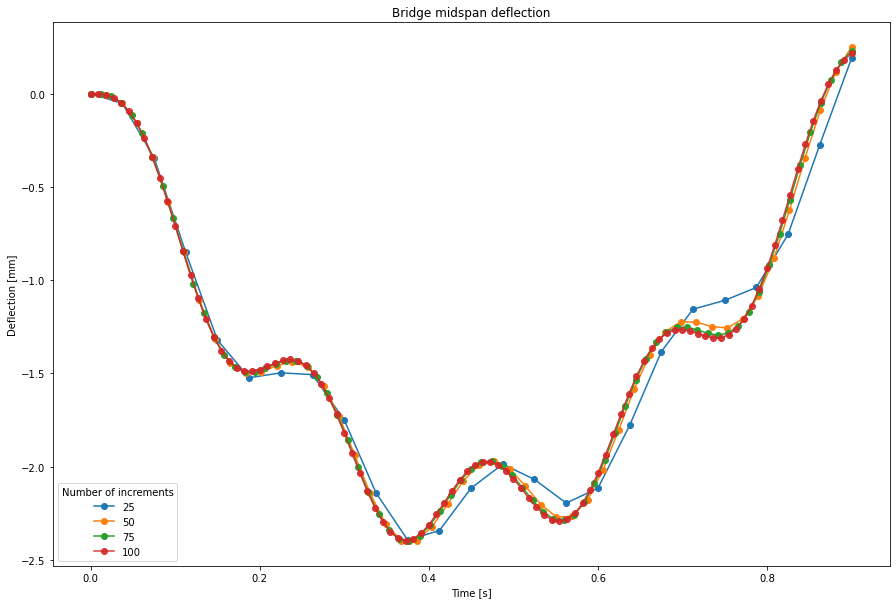

In [22]:
#############################
# RUNGE-KUTTA METHOD
# Investigate convergence
#############################

# Initialise empty dictionaries to store results
X1 = {}
Y1 = {}
Z1 = {}
X2= {}
Y2= {}
Z2= {}
t_dictionary = {}

numpoints_list = [25, 50, 75, 100]
#numpoints_list = [75]

# Constants
L = 25 #[m]
m = 2303 #[kg/m]
M_v = 5750 #[kg]
g = 9.81 #[m/s^2]
v = (100E3)/ (60 * 60) #27.778[m/s]
w_1 = 30.02 #[rad/s]
w_v = 16.66 #[rad/s]
#k = 1595E3

#Groups
a = (2 * M_v) / (m * L)
b = (np.pi * v ) / L

def dx1dt(y1):
    dx1dt = y1
    return dx1dt

def dy1dt(x1, x2, t):
    dy1dt = -(a * g * np.sin(b * t)) + (x2 * (a * w_v * w_v * np.sin(b * t))) - (x1 * ((a * w_v * w_v * np.sin(b * t) * np.sin(b * t)) + (w_1 * w_1)))
    return dy1dt

def dx2dt(y2):
    dx2dt = y2
    return dx2dt

def dy2dt(x1, x2, t):
    dy2dt = (x1 * (w_v * w_v * np.sin(b * t))) - (x2 * w_v * w_v)
    return dy2dt

for numpoints in numpoints_list:
    
    # Time vector
    t_start = 0.0 # [s]
    t_end = 0.9 # [s]
    t = np.linspace(t_start, t_end, numpoints) # a vector containing the times at which solutions will be estimated
    dt = (t_end - t_start) / numpoints # the time increment used, given the start and end times and the number of increments
    fs = 1/dt # the effective sampling frequency
    
    # Initial conditions
    x1 = 0.0
    y1 = 0.0
    x2 = 0.0
    y2 = 0.0
    
    # Results vectors
    x1_res = np.zeros(len(t)).astype(float)
    y1_res = np.zeros(len(t)).astype(float)
    x2_res = np.zeros(len(t)).astype(float)
    y2_res = np.zeros(len(t)).astype(float)

    for i in range(len(t)):

        # Store results
        x1_res[i] = x1
        y1_res[i] = y1
        x2_res[i] = x2
        y2_res[i] = y2

        # Increment and store results temporarily
        k1x1 = dt * dx1dt(y1)
        k1y1 = dt * dy1dt(x1, x2, t[i])
        k1x2 = dt * dx2dt(y2)
        k1y2 = dt * dy2dt(x1, x2, t[i])

        k2x1 = dt * dx1dt(y1 + 0.5 * k1y1)
        k2y1 = dt * dy1dt((x1 + 0.5 * k1x1), (x2 + 0.5 * k1x2), (t[i] + 0.5 * dt))
        k2x2 = dt * dx2dt(y2 + 0.5 * k1y2)
        k2y2 = dt * dy2dt((x1 + 0.5 * k1x1), (x2 + 0.5 * k1x2), (t[i] + 0.5 * dt))

        k3x1 = dt * dx1dt(y1 + 0.5 * k2y1)
        k3y1 = dt * dy1dt((x1 + 0.5 * k2x1), (x2 + 0.5 * k2x2), (t[i] + 0.5 * dt))
        k3x2 = dt * dx2dt(y2 + 0.5 * k2y2)
        k3y2 = dt * dy2dt((x1 + 0.5 * k2x1), (x2 + 0.5 * k2x2), (t[i] + 0.5 * dt))

        k4x1 = dt * dx1dt(y1 + k3y1)
        k4y1 = dt * dy1dt((x1 + k3x1), (x2 + k3x2), (t[i] + dt))
        k4x2 = dt * dx2dt(y2 + k3y2)
        k4y2 = dt * dy2dt((x1 + k3x1), (x2 + k3x2), (t[i] + dt))

        # Assign temporary results to placeholders
        x1_next = x1 + (k1x1 / 6) + (k2x1 / 3) + (k3x1 / 3) + (k4x1 / 6)
        y1_next = y1 + (k1y1 / 6) + (k2y1 / 3) + (k3y1 / 3) + (k4y1 / 6)
        x2_next = x2 + (k1x2 / 6) + (k2x2 / 3) + (k3x2 / 3) + (k4x2 / 6)
        y2_next = y2 + (k1y2 / 6) + (k2y2 / 3) + (k3y2 / 3) + (k4y2 / 6)

        x1 = x1_next
        y1 = y1_next
        x2 = x2_next
        y2 = y2_next

    # Estimate accelerations
    z1_res = np.gradient(y1_res, dt)
    z2_res = np.gradient(y2_res, dt)
    
    # Update dictionaries of results
    X1.update({numpoints: x1_res})
    Y1.update({numpoints: y1_res})
    Z1.update({numpoints: z1_res})
    
    X2.update({numpoints: x2_res})
    Y2.update({numpoints: y2_res})
    Z2.update({numpoints: z2_res})
    
    t_dictionary.update({numpoints: t})
    
# Plot results
plt.figure(figsize = (15,10))
plt.plot(t_dictionary[25], 1E3 * X1[25], 'o-')
plt.plot(t_dictionary[50], 1E3 * X1[50], 'o-')
plt.plot(t_dictionary[75], 1E3 * X1[75], 'o-')
plt.plot(t_dictionary[100], 1E3 * X1[100], 'o-', alpha = 25)
plt.legend(numpoints_list, title = "Number of increments")
plt.title("Bridge midspan deflection")
plt.xlabel("Time [s]")
plt.ylabel("Deflection [mm]")
plt.show()